In [54]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.optimize import curve_fit
from scipy.signal import find_peaks

Data tryk! 

In [10]:
#p = np.array([0.25,0.5,0.75,1.0,1.5])
#m = [17,29,39,50,73]

p = [1, 0.5, 0.75,0.25, 0.6, 0.8]
m = [[46,47,46,44,46],[24,23,21,20,21,22,22,21],[35,34,32,30,31,34,36,34,34],[11,11,12,12,11],[28,26,25,26,27],[35,36,35,35,37]]
y_error = [np.std(i,ddof=1)/np.sqrt(len(i)) for i in m] #Skal have fejl for tælletal? 
m = [np.mean(i) for i in m]
x_error = [0.05 if i!=0 else 0.125/2 for i in range(len(m))]

#[34,36]

[ 4.57671568e+01 -1.53260489e-02]
1.0002329145093614


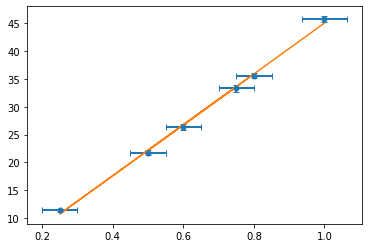

In [11]:
l = 0.063 #m
lambd = 633e-9 #m


def fit_func(x,a,b): 
    return a*(p+b)

p_opt, p_cov = curve_fit(fit_func,p,m)

print(p_opt)
print(p_opt[0]*lambd/(2*l)*1.013+1)

plt.errorbar(p,m,yerr=y_error,xerr=x_error,fmt='o',ms=5,lw=2,capsize=3)
plt.plot(p,fit_func(p,p_opt[0],p_opt[1]))


Data til Wave-plate!

In [52]:
def load_file(name): 
    data = np.loadtxt('data/' + name + '.csv',skiprows=2,delimiter=',').T 
    #data = np.loadtxt('E:\Eksperimentel_fysik\Michelson_interferometer\\' + name + '.csv',skiprows=2,delimiter=',').T
    return data

def find_slopes(top, bot):
    rise = []
    fall = []
    first_rising = top[0] > bot[0]          
    last_rising = top[-1] > bot[-1]
    max_len = max(len(top), len(bot))
    if first_rising and last_rising:
        fall = [(top[i], bot[i+1]) for i in range(max_len - 1)]
        rise = [(bot[i], top[i] ) for i in range(max_len)]
    elif first_rising and not last_rising:
        fall = [(top[i], bot[i+1]) for i in range(max_len - 1)]
        rise = [(bot[i],top[i]) for i in range(max_len - 1)]
    elif not first_rising and not last_rising:
        fall = [(top[i], bot[i]) for i in range(max_len)]
        rise = [(bot[i],top[i+1]) for i in range(max_len - 1)]
    elif not first_rising and last_rising:
        fall = [(top[i], bot[i]) for i in range(max_len - 1)]
        rise = [(bot[i],top[i+1]) for i in range(max_len -1)]
    else:
        print('You fucked it up fam')
    return rise, fall

def slope_intensity(slope,volt,intensity): 
    volt_slope = volt[slope[0]:slope[1]+1]
    intensity_slope = intensity[slope[0]:slope[1]+1]
    unique_volt = sorted(list(set(volt_slope)))
    slope_int = [np.mean([intensity_slope[i] for i,volt_j in enumerate(volt_slope) if volt_j == volt_i]) for volt_i in unique_volt]
    return slope_int, unique_volt

def mean_several_files(max_file_num,file_name,N,to_print=False): 
    rise_ints = []
    volt_to_return = []
    for i in range(max_file_num): 
        print(i)
        
        if i < 9: 
            time,intensity,volt = load_file(f'{file_name}_0{i+1}')
        else: 
            time,intensity,volt = load_file(f'{file_name}_{i+1}')
        if len(volt) < 1000:
            continue 
        else: 
            max_peaks = find_peaks(volt,distance=1000,width=100)[0]
            min_peaks = find_peaks(-1*volt,distance=1000,width=100)[0]
            rise_slopes,fall_slopes = find_slopes(max_peaks,min_peaks)

            for rise in rise_slopes:
                s_int,unique_volt = slope_intensity(rise,volt,intensity)
                if len(unique_volt) == N:
                    rise_ints.append(s_int)
                    volt_to_return = unique_volt
                if to_print: 
                    print(f'Rise:{len(unique_volt)}')
                
    rise_mean = np.mean(rise_ints,axis=0)
    rise_error = np.std(rise_ints,ddof=1,axis=0)/np.sqrt(len(rise_ints))
    return volt_to_return,rise_mean,rise_error


def find_N(max_file_num,file_name): 
    def most_frequent(List):
        return max(set(List), key = List.count)
    
    N_list = []
    
    for i in range(max_file_num): 
        print(i)
        
        if i < 9: 
            time,intensity,volt = load_file(f'{file_name}_0{i+1}')
        else: 
            time,intensity,volt = load_file(f'{file_name}_{i+1}')
        if len(volt) < 1000:
            continue 
        else: 
            max_peaks = find_peaks(volt,distance=1000,width=100)[0]
            min_peaks = find_peaks(-1*volt,distance=1000,width=100)[0]
            rise_slopes,fall_slopes = find_slopes(max_peaks,min_peaks)

            for rise in rise_slopes:
                s_int,unique_volt = slope_intensity(rise,volt,intensity)
                N_list.append(len(unique_volt))
    return most_frequent(N_list)

In [94]:
def Gauss_fit(x,y,y_err,guess,to_plot=False): 
    def Gauss(x,a,b,c): 
        return a*np.exp(-(x-b)**2/(2*c**2))
    p_opt, p_cov = curve_fit(Gauss,x,y,p0=guess, sigma=y_err, absolute_sigma=True)
    p_err = np.sqrt(np.diag(p_cov))
    
    if to_plot: 
        plt.plot(x,y)
        plt.plot(x,Gauss(x,p_opt[0],p_opt[1],p_opt[2]))
    return p_opt[0],p_err[0] #Retunerer middelværdien! 


def find_single_max(x,y,y_err,peak_nr=1,width=5,to_plot=False): 
    peaks = find_peaks(y,width=2)[0]
    peak = peaks[peak_nr]

    y_fit = y[peak-width:peak+width+1]
    x_fit = x[peak-width:peak+width+1]
    y_fit_err = y_err[peak-width:peak+width+1]
    guess = [x[peak],5,5]
    mean,mean_err = Gauss_fit(x_fit,y_fit,y_fit_err,guess,to_plot=to_plot)
    return mean,mean_err
        
    
def find_max(x,y,y_err,width=5): 
    mean_list = []
    error_list = []
    
    peaks = find_peaks(y,width=2)[0]

    for peak in peaks: 
        if peak+1 < 6 or len(x)-peak+1 < 6: 
            width = min(peak,len(x)-peak+1)
        y_fit = y[peak-width:peak+width+1]
        x_fit = x[peak-width:peak+width+1]
        y_fit_err = y_err[peak-width:peak+width+1]
        guess = [x[peak],5,5]
        mean,mean_err = Gauss_fit(x_fit,y_fit,y_fit_err,guess)
        mean_list.append(mean)
        error_list.append(mean_err)
        
    mean_list = np.array(mean_list)
    error_list = np.array(error_list)
    filter_list = np.argsort(mean_list)
    mean_list = mean_list[filter_list]
    error_list = error_list[filter_list]
    return mean_list,error_list

In [80]:
angles = ['Test1','Test2']
N_list = []

for angle in angles: 
    N_list.append(find_N(5,f'{angle}/{angle}'))
print(N_list)

0
1
2
3
4
0
1
2
3
4
[92, 92]


0
1
2
3
4
[11 39 68]
39


(5.788216342591543, 0.008026324027098193)

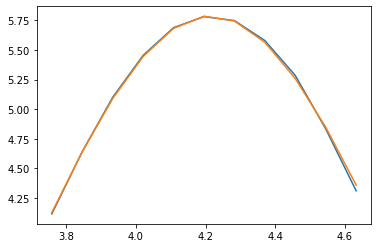

In [88]:
volts, mean, error = mean_several_files(5,f'{angles[0]}/{angles[0]}',N=N,to_print=False)
find_single_max(volts,mean,error)

#plt.plot(volts,mean)

0
1
2
3
4
5.788216342591543
0
1
2
3
4
5.728692910486519


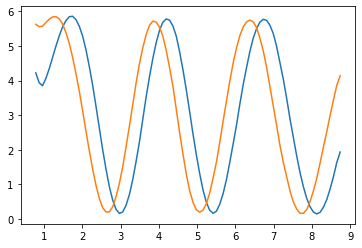

In [98]:
max_ints = []
max_error = []

for N,angle_name in zip(N_list,angles): 
    volts,mean,error = mean_several_files(5,f'{angle_name}/{angle_name}',N=N,to_print=False)
    top_int,top_error = find_single_max(volts,mean,error,to_plot=False)
    max_ints.append(top_ints)
    max_error.append(top_error)
    plt.plot(volts,mean)